#### Import Packages & Set Up Useful Functions

In [21]:
import numpy as np
import math
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime
from scipy.special import expi as Ei
%matplotlib inline
plt.style.use('fivethirtyeight')

In [22]:
def plotFunction(x, y):
    temp_figure = plt.figure()
    plt.plot(x, y)    
    plt.scatter(x,y)
    plt.title(y.name + " vs. " + x.name)
    plt.xlabel(x.name, fontsize=16)
    plt.ylabel(y.name, fontsize=16)
    plt.show()
    
def printDF(df):
    print(df.head(n=8).round(3))

# QUESTION 1

<img src="https://i.gyazo.com/e6e2d8cc336ba0b81afae0953b35e6a7.png">

M_s = 0.1441
Eabt = 1.0269997695797874
Vp = 319649.4790275181
Wibt = 87650.74432911856
Qibt = 0.267
Wi100 = 79425.6050778847


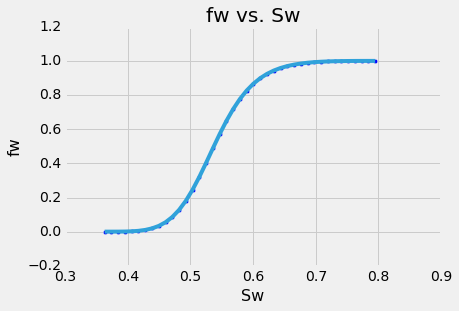

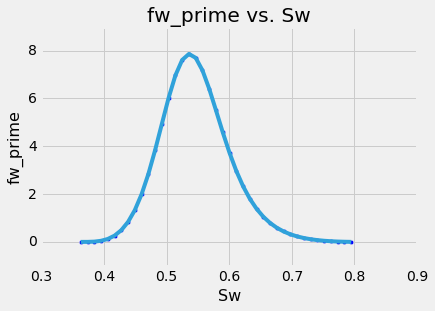

      Sw  Sw_star    kro    krw     fw  fw_prime
0  0.363    0.000  1.000  0.000  0.000     0.000
1  0.374    0.025  0.937  0.000  0.000     0.001
2  0.385    0.050  0.877  0.000  0.000     0.011
3  0.395    0.075  0.819  0.000  0.001     0.046
4  0.406    0.100  0.764  0.000  0.002     0.122
5  0.417    0.125  0.711  0.000  0.005     0.262
6  0.428    0.150  0.660  0.001  0.010     0.491
7  0.439    0.175  0.611  0.001  0.019     0.837


In [23]:
Sw_star = 1
phi = .206
k = 23 #md
Soi = .637 
Sor = .205
Swr = 1-Soi
Swi = Swr
mu_w = 1 #cp
mu_o  = 10 #cp 
h = 20 #ft
kro = (1-Sw_star)**2.56
krw = .78*Sw_star**3.72
Bo = 1
Bw = 1
A = 10 #acres
u = 20

data = pd.DataFrame({"Sw": (np.linspace(Swi, 1, num=60))})
data['Sw_star'] = (data['Sw'] - Swr)/(1-Sor - Swr)
data['kro'] = (1-data.Sw_star)**2.56
data['krw'] = .78*data.Sw_star**3.72
data['fw'] = 1/(1 + (data.kro*mu_w)/(data.krw*mu_o))
data['fw_prime'] = (data.fw - data.fw.shift(+1).set_value(0, 0.00))/(data.Sw - data.Sw.shift(+1).set_value(0, 0.00))

Swf = .58
Swf_avg = .63
M_s = (.136/1) + (.081/10)
Eabt = .54602036 + .03170817/M_s + .30222997/math.exp(M_s) - .00509693*M_s
Vp = (43560/5.6145)*A*h*phi
Wibt = Vp*Eabt*(Swf_avg - Swi)
Qibt = Wibt/(Eabt*Vp)
Wi100 = Wibt * math.exp((1-Eabt)/0.274)

print("M_s = " + str(M_s))
print("Eabt = " + str(Eabt))
print("Vp = " + str(Vp))
print("Wibt = " + str(Wibt))
print("Qibt = " + str(Qibt))
print("Wi100 = " + str(Wi100))

plotFunction(data.Sw, data.fw)
plotFunction(data.Sw, data.fw_prime)

printDF(data)


### Set up fw_prime vs Sw table in ascending order for fw_prime to get interpolate data later
The fw_prime values that we are going to calculate for the displacement table will be used to extrapolate for Sw values. The values picked were after the saturation front, meaning it's later than the peak of the curve at Sw = .54 and fw_prime = 7.8.

In [24]:
temp_table = pd.concat([data['fw_prime'], data['Sw']], axis=1, keys=['fw_prime', 'Sw'])
temp_table = (temp_table.ix[18:40])
temp_table = temp_table.sort_values('fw_prime', ascending=True)


### Set up the Displacement Table
First generating 10 Wi values from Wibt to Wi100 and 10 Wi values after Wi100  

In [29]:
df1 = pd.DataFrame({"Wi": (np.linspace(Wibt, Wi100, num=15))})
df2 = pd.DataFrame({"Wi": (np.linspace(Wi100, Wi100*2, num=15))})
frames = [df1, df2]
disp_table = pd.concat(frames)
print(disp_table)

               Wi
0    87650.744329
1    87063.234383
2    86475.724436
3    85888.214490
4    85300.704543
5    84713.194597
6    84125.684650
7    83538.174704
8    82950.664757
9    82363.154810
10   81775.644864
11   81188.134917
12   80600.624971
13   80013.115024
14   79425.605078
0    79425.605078
1    84903.233014
2    90380.860951
3    95858.488887
4   101336.116824
5   106813.744760
6   112291.372696
7   117769.000633
8   123246.628569
9   128724.256506
10  134201.884442
11  139679.512378
12  145157.140315
13  150634.768251
14  156112.396188
15  161590.024124
16  167067.652060
17  172545.279997
18  178022.907933
19  183500.535870
20  188978.163806
21  194455.791742
22  199933.419679
23  205411.047615
24  210888.675552
25  216366.303488
26  221843.931424
27  227321.559361
28  232799.187297
29  238276.815234


### Calculate Displacement Table
1) Calculate 
$\frac{Wi}{Wibt}$

2) Calculate 
$E_A = E_{A,BT} + .274ln(\frac{Wi}{Wibt})$

3) Replace any $E_A$ >= 1 with 1

4) Calculate Wi

For Wi > Wi100

$E_A = E_{A,BT} + .274ln(\frac{Wi}{Wibt})$

$Q_{i} = Q_{i100} + \frac{W_i-W{i100}}{V_p}$ 

For Wibt < Wi < Wi100
<img src="https://i.gyazo.com/aca423c08e72b6f0fc83ab1883d5262e.png" style="width: 50%;">

5) Calculate fw'

6) Look up & interpolate Sw values from fw from the original fw' vs. Sw table to get Sw2

7) Calculate $Sw^*_2$

$Sw^*_2= \frac{Sw - Swr}{1-Sor- Swr}$

8) Calculate $k_{ro2}$

$k_{ro2} = (1- Sw^*_2)^{2.56}$

8) Calculate $k_{rw2}$

$k_{rw2} = (.78Sw^*_{2})^{3.72}$

9) Calculate $f_{w2}$

$f_{w2} = \frac{1}{(1 + \frac{k_{ro2}\mu_w}{k_{rw2}\mu_o})}$

10) Calculate $fo_2$

$f_{o2} = 1 - f_{w2}$

11) Calculate $S_{w5}$

$S_{w5} = S_{w2} + f_{o2}Qi^*$

12) Calculate Np

$N_p = E_{A}(S_{w5} - S_{wi})$

13) Calculate WOR

For $E_{A} < 1$, calculate $\frac{dNpy}{dWi}$, then calculate WOR using Eq 4.27

<img src="https://i.gyazo.com/4ba499544e2d47a93d2e2178210a1248.png" style="width: 50%;">

For $E_{A} >= 1$, calculate $\frac{dNpy}{dWi}$, then calculate WOR using:

$WOR = \frac{f_{w2}}{f_{o2}}$


Qibt_star = 0.267
a1 = 3.748549158966224
Ei(a1) = 16.5008728247

Displacement Table
          Wi  Wi/Wibt  Ea     a2  Ei(a2)   4.20   4.19  Qi_star  fw_prime  \
0  87650.744    1.000   1  3.749  16.501  1.000  0.882    0.882     1.134   
1  87063.234    0.993   1  3.742  16.425  0.993  0.880    0.880     1.137   
2  86475.724    0.987   1  3.735  16.349  0.987  0.878    0.878     1.139   
3  85888.214    0.980   1  3.728  16.272  0.980  0.876    0.876     1.141   
4  85300.705    0.973   1  3.721  16.196  0.973  0.874    0.874     1.144   
5  84713.195    0.966   1  3.714  16.120  0.966  0.873    0.873     1.146   
6  84125.685    0.960   1  3.708  16.043  0.960  0.871    0.871     1.148   
7  83538.175    0.953   1  3.700  15.966  0.953  0.869    0.869     1.151   

     Sw2  Sw_star2   kro2   krw2    fw2    fo2    Sw5     Np   dNdW  WOR-Ea<1  \
0  0.652     0.669  0.059  0.174  0.967  0.033  0.681  0.318  0.217     3.123   
1  0.652     0.668  0.059  0.174  0.967  0.033  0.681  0.318

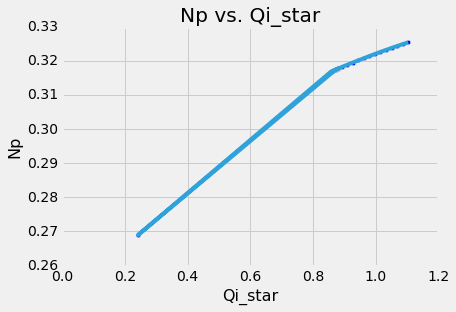

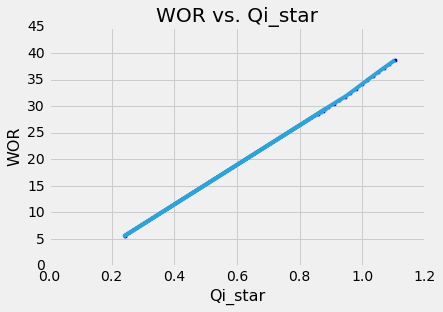

In [26]:
disp_table['Wi/Wibt'] = disp_table.Wi/Wibt

disp_table['Ea'] = Eabt + .274*scipy.log(disp_table.Wi/Wibt)
disp_table['Ea'] = np.where(disp_table['Ea'] <= 1, disp_table['Ea'], 1)

Qibt_star = Wibt/Eabt/Vp

print("Qibt_star = " + str(Qibt_star))

a1 = 3.65*Eabt
print('a1 = ' + str(a1))
print('Ei(a1) = ' + str(Ei(a1)))
disp_table['a2'] = a1 + scipy.log(disp_table.Wi/Wibt)
disp_table['Ei(a2)'] = Ei(disp_table['a2'])
disp_table['4.20'] =  1 + (a1*math.exp(-1*a1)*(Ei(disp_table.a2) - Ei(a1)))

# From the 4.20 column for the first Ea value, Q = Qi100_star = .856
Qi100_star = 0.856  

disp_table['4.19'] = Qi100_star + ((disp_table.Wi - Wi100)/Vp)
disp_table['Qi_star'] = np.where(disp_table['Wi'] <= Wi100, disp_table['4.20']*Qibt_star, disp_table['4.19'])
disp_table['fw_prime'] = 1/disp_table['Qi_star']

# INTERPOLATE FW_PRIME FROM THE ORIGINAL FW_PRIME VS SW
disp_table['Sw2'] = np.interp(disp_table['fw_prime'], temp_table['fw_prime'], temp_table['Sw'])
disp_table['Sw_star2'] = (disp_table['Sw2'] - Swr)/(1-Sor- Swr)
disp_table['kro2'] = (1-disp_table.Sw_star2)**2.56
disp_table['krw2'] = .78*disp_table.Sw_star2**3.72
disp_table['fw2'] = 1/(1 + (disp_table.kro2*mu_w)/(disp_table.krw2*mu_o))
disp_table['fo2'] = 1 -disp_table.fw2


#USING EQ 4.12 IN WILLHITE FOR Fw5
disp_table['Sw5'] = disp_table.Sw2 + disp_table.fo2*disp_table.Qi_star
disp_table['Np'] = disp_table.Ea*(disp_table.Sw5 - Swi)

# EA < 1  -> dNpy/Dwi -> WOR
# EA >= 1 -> WOR = Fw2/FO2
disp_table['dNdW'] = (.274*Wibt/disp_table.Wi)*(1/Eabt)*((Swf-Swi)/(Swf_avg-Swi))
disp_table['WOR-Ea<1'] = (1-disp_table.fo2)*(1-disp_table.dNdW)/(disp_table.fo2*(1-disp_table.dNdW) + disp_table.dNdW)
disp_table['WOR'] = np.where(disp_table['Ea'] < 1, disp_table['WOR-Ea<1'], (disp_table.fw2/disp_table.fo2))

print("\nDisplacement Table")
printDF(disp_table)

plotFunction(disp_table.Qi_star, disp_table.Np)
plotFunction(disp_table.Qi_star, disp_table.WOR)


# Question 2
<img src="https://i.gyazo.com/923696a6720fbad7bc241ac981bea9ff.png">

<img src="https://i.gyazo.com/095f589811fdb1355d3f9402d02ad8ac.png">
<img src="https://i.gyazo.com/a99906ae445c64634fd3867fe5cea468.png">

# Question 3
<img src="https://i.gyazo.com/846e9557590c77eb5fffb3daa86246d9.png">

## 3a

From lecture 24

$\phi + u\frac{\partial c}{\partial t} + \phi k_l \frac{\partial^2 C}{\partial x^2} c$

IC: @ t = 0, 0 < x < L, C = C1

BC: @ t = 0, x = 0    , C = C2

BC: @ x -> $\infty$     , C = C1


Solution
$C_D = \frac{1}{2} erfc\frac{x_D - t_d}{2\sqrt{t_D/N_{Pe}}}$ + 2nd term

Where: 2nd term is negligible in this case

$C_D = \frac{C-C1}{C2-C1}$
    
$x_D = \frac{x}{L}$

$t_D = \textrm{Number Injected} = \frac{V_{injected}}{V_{pore}}$
 
$N_{pe} = \textrm{Peclect Number} = \frac{uL}{\phi K_L}$

Since erfc = 1-erf

$2C_D = 1 - erf(\frac{x_D - t_D}{2\sqrt{t_D/N_{Pe}}})$

At Ce (where $x_d$ = 1)

$1 - 2C_D = erf(\frac{1-t_D}{2\sqrt{1/N_{Pe}}\sqrt{t_D}})$

$\frac{1-t_D}{\sqrt{t_D}} = \frac{2}{\sqrt{N_{pe}}} \ erf^{-1}(1-2C_D)$

From this equation, we can see that there's a linear relationship:

$x = \frac{1-t_D}{\sqrt{t_D}}$

$y = erf^{-1}(1-2C_D)$

$m = \textrm{slope} = \frac{2}{\sqrt{N_{pe}}}$

## 3b

- Since $t_d$ = 1 and $x_d$ = 1, we can read from the table that $C_d$ = .5
- At $C_d$ = .5, PV = 100 cm

1) Normalize Volume Produced by dividing it by Pore Volume

$t_d = \frac{Vp}{PV}$

2) Calculate $x = erf^-1(1-2C_d)$

3) Calculate $y = \frac{1-t_d}{\sqrt{t_d}}$

4) Run a linear regression between x & y, the slope m will be equal to $2/\sqrt{N_{pe}}$


Finding the slope 2/sqrt(Npe)
Linear Regression: y = 0.253308062041x + 0.0222768799403
R value = 0.98877824266


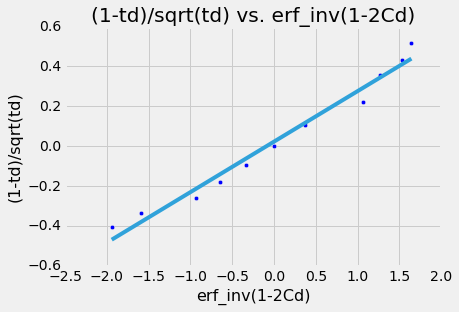

    Vol Prod     Ce    td      x      y   y_lr
0         60  0.010  0.60  1.645  0.516  0.439
1         65  0.015  0.65  1.534  0.434  0.411
2         70  0.037  0.70  1.263  0.359  0.342
3         80  0.066  0.80  1.065  0.224  0.292
4         90  0.300  0.90  0.371  0.105  0.116
5        100  0.502  1.00 -0.004  0.000  0.021
6        110  0.685  1.10 -0.341 -0.095 -0.064
7        120  0.820  1.20 -0.647 -0.183 -0.142
8        130  0.906  1.30 -0.931 -0.263 -0.214
9        140  0.988  1.40 -1.596 -0.338 -0.382
10       150  0.997  1.50 -1.943 -0.408 -0.470


In [27]:
q3 = pd.read_csv(r"C:\Users\jenng\OneDrive\School\Class of 2017 (UT)\Misc\PGE 323L -  Reservoir II\Homework\Homework 8\Question3.csv", sep=',',header=0)


q3['td'] = q3['Vol Prod']/100
q3['x'] = scipy.special.erfinv(1 - 2*q3.Ce)
q3['y'] = (1-q3['td'])/np.sqrt(q3['td'])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(q3.x,q3.y)

print("Finding the slope 2/sqrt(Npe)")
print("Linear Regression: y = " + str(slope) + "x + " + str(intercept))
print("R value = " + str(r_value))

q3['y_lr'] = slope*q3.x + intercept

temp_figure = plt.figure()
plt.scatter(q3.x, q3.y)
plt.plot(q3.x, q3.y_lr )
plt.title("(1-td)/sqrt(td) vs. erf_inv(1-2Cd)")
plt.xlabel("erf_inv(1-2Cd)", fontsize=16)
plt.ylabel("(1-td)/sqrt(td)", fontsize=16)
plt.show()

print(q3.round(3))


###  Calculate for dispersitivity coefficient and dispersitivity

5) Calculate for $N_{pe}$

$N_{pe} = (\frac{2}{m})^2$

6) Calculate for $K_L$

$K_L = \frac{uL}{N_{pe}\phi}$

7) Calculate for $\alpha_L$

$\alpha_L = \frac{K_l}{u} $

In [28]:
Npe = (2/slope)**2
u = 20 #cm
L = .5 #m

K_l = u*L/Npe/phi
a_l = K_l/u

print ("Npe = " + str(Npe))
print ("K_l = " + str(K_l))
print ("a_l = " + str(a_l))

Npe = 62.3393065136
K_l = 0.778701144354
a_l = 0.0389350572177
